In [1]:
from mlrl.maze.maze_env import make_maze_env
from mlrl.maze.maze_state import RestrictedActionsMazeState
from mlrl.meta.search_tree import SearchTree
from mlrl.meta.meta_env import MetaEnv
from mlrl.maze.maze_tree_policy_renderer import render_tree_policy
from mlrl.maze.manhattan_q import ManhattanQHat

from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.environments.gym_wrapper import GymWrapper
from tf_agents.environments.batched_py_environment import BatchedPyEnvironment

pygame 2.1.0 (SDL 2.0.16, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
def create_meta_env(seed=0, enable_rendering=False, **kwargs):
    object_env = make_maze_env(
        seed=seed, maze_size=(5, 5), goal_reward=1,
        generate_new_maze_on_reset=True, enable_render=enable_rendering
    )

    q_hat = ManhattanQHat(object_env)
    extract_state = RestrictedActionsMazeState.extract_state(object_env)
    initial_tree = SearchTree(object_env, extract_state, q_hat)
    meta_env = MetaEnv(object_env, initial_tree, max_tree_size=32,
                       tree_policy_renderer=render_tree_policy,
                       split_mask_and_tokens=True,
                       one_hot_action_space=False,
                       expand_all_actions=True,
                       finish_on_terminate=True, **kwargs)
    return meta_env

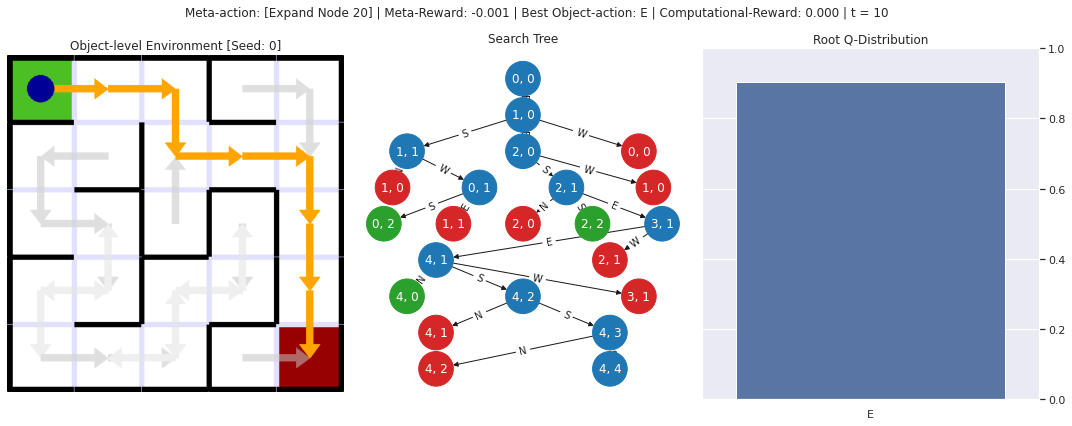

In [3]:
meta_env = create_meta_env(enable_rendering=True)
for action in [1, 2, 3, 7, 4, 10, 14, 15, 18, 21]:
    meta_env.step(action)
meta_env.render(plt_show=True);

In [4]:
obs = meta_env.get_observation()

In [5]:
def get_a_star_action(meta_env: MetaEnv, action_mask: list) -> int:
    """
    Chooses the node expansion according the the A* search algorithm,
    i.e. choose node n that maximises f(n) = g(n) + h(n), where g(n) is the return
    to reach the node and h(n) is the "heuristic" return from the node.
    In other words, the expected return from the root if passing through the node.
    """
    available_expansions = [
        i for i, can_take in enumerate(action_mask)
        if i > 0 and can_take
    ]

    if not available_expansions:
        return 0

    return max(available_expansions,
               key=lambda a: meta_env.tree.node_list[a - 1].get_exp_root_return())


from tf_agents.policies.py_policy import PyPolicy
from tf_agents.trajectories import policy_step
import numpy as np
import tensorflow as tf


class AStarPolicy(PyPolicy):

    def __init__(self, env: BatchedPyEnvironment):
        super().__init__(env.time_step_spec(), env.action_spec())
        self.env = env
        self.batch_size = env.batch_size

    def _action(self, time_step, policy_state, seed=None):
        obs = time_step.observation

        action = tf.convert_to_tensor([
            get_a_star_action(self.env.envs[i], obs['action_mask'][i])
            for i in range(self.batch_size)
        ], dtype=self.action_spec.dtype)

        return policy_step.PolicyStep(action, policy_state, info=())

In [11]:
meta_env = BatchedPyEnvironment([
    GymWrapper(create_meta_env(enable_rendering=True, min_computation_steps=5, seed=seed))
    for seed in range(16)
], multithreading=True)

ts = meta_env.reset()

In [12]:
a_star_policy = AStarPolicy(meta_env)
a_star_policy.action(ts)

PolicyStep(action=<tf.Tensor: shape=(16,), dtype=int64, numpy=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])>, state=(), info=())

In [13]:
from mlrl.experiments.eval_runner import EvalRunner

evaluator = EvalRunner(eval_steps=16*64, eval_env=meta_env, policy=a_star_policy, use_tf_function=False)

In [14]:
evaluator.run()

1036/1024 [==============================] - 28s 27ms/step - AverageReturn: 1.0253
Evaluation stats:
EvalNumberOfEpisodes: 60.000, EvalEnvironmentSteps: 1036.000, EvalAverageReturn: 1.420, EvalAverageEpisodeLength: 15.800, EvalTime: 27.608


{'EvalNumberOfEpisodes': 60,
 'EvalEnvironmentSteps': 1036,
 'EvalAverageReturn': 1.419556,
 'EvalAverageEpisodeLength': 15.8,
 'EvalTime': 27.608179330825806}

In [10]:
evaluator.progbar.max_progress

128

In [11]:
evaluator.eval_actor

AttributeError: 'Actor' object has no attribute 'steps'

In [13]:
from mlrl.utils.render_utils import create_and_save_policy_eval_video, embed_mp4
embed_mp4(create_and_save_policy_eval_video(a_star_policy, meta_env, max_steps=60, rewrite_rewards=True))

TypeError: expected str, bytes or os.PathLike object, not list

In [ ]:
from mlrl.utils.render_utils import create_random_policy_video, embed_mp4
meta_env = BatchedPyEnvironment([
    GymWrapper(create_meta_env(enable_rendering=True, min_computation_steps=5))
    for _ in range(2)
], multithreading=True)
embed_mp4(create_random_policy_video(meta_env, max_steps=60, rewrite_rewards=True))

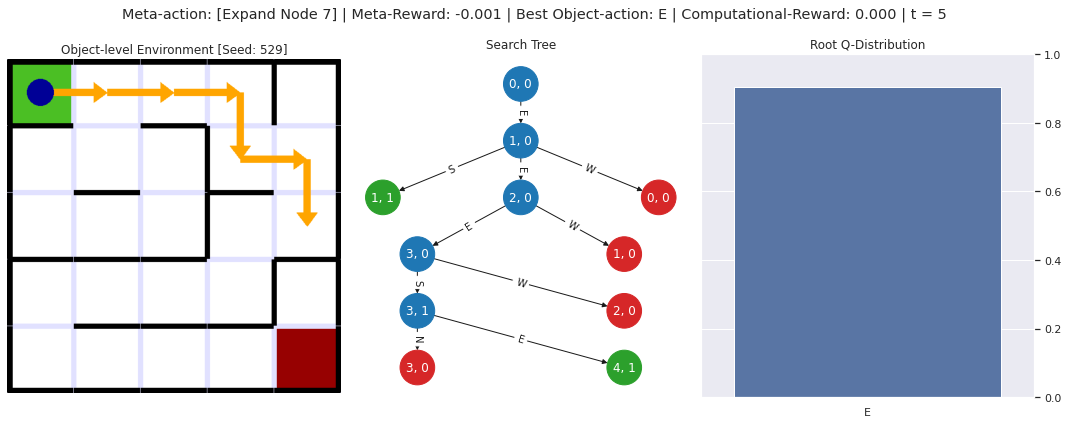

Estimating value of new policy:
 {MazeState(0, 0)}
|---[E, -0.004]--> {MazeState(1, 0)}
	|---[S, -0.004]--> (MazeState(1, 1))
	|---[E, -0.004]--> {MazeState(2, 0)}
		|---[E, -0.004]--> {MazeState(3, 0)}
			|---[S, -0.004]--> {MazeState(3, 1)}
				|---[N, -0.004]--> {MazeState(3, 0)}
				|---[E, -0.004]--> {MazeState(4, 1)}
					|---[N, -0.004]--> (MazeState(4, 0))
					|---[S, -0.004]--> (MazeState(4, 2))
					|---[W, -0.004]--> {MazeState(3, 1)}
			|---[W, -0.004]--> {MazeState(2, 0)}
		|---[W, -0.004]--> {MazeState(1, 0)}
	|---[W, -0.004]--> {MazeState(0, 0)}
P(E | MazeState(0, 0)) = 1.0
P(S | MazeState(1, 0)) = 1.0
P(E | MazeState(1, 1)) = 1.0
Leaf evaluation: Q-hat(MazeState(1, 1), E) = 0.93139
Value(MazeState(1, 1)) = 0.93139
Recursive Q-hat(MazeState(1, 0), S) = 0.918 
Value(MazeState(1, 0)) = 0.91807
Recursive Q-hat(MazeState(0, 0), E) = 0.905 
Value(MazeState(0, 0)) = 0.90489

Estimating value of prior policy:
 {MazeState(0, 0)}
|---[E, -0.004]--> {MazeState(1, 0)}
	|---[S, -0.

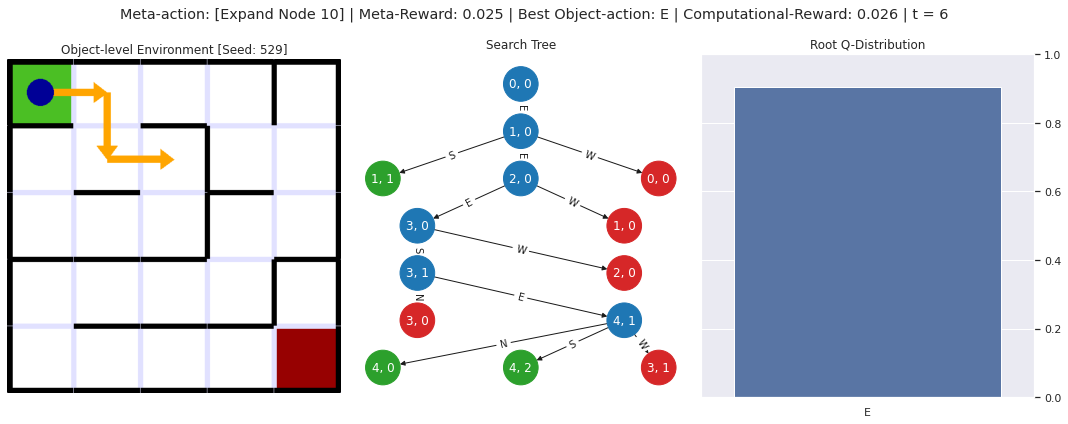

In [7]:
meta_env = create_meta_env(seed=529)
for a in [1, 2, 4, 6, 8]:
    meta_env.step(a)
meta_env.render(plt_show=True)
meta_env.step(11, verbose=True)
meta_env.render(plt_show=True);

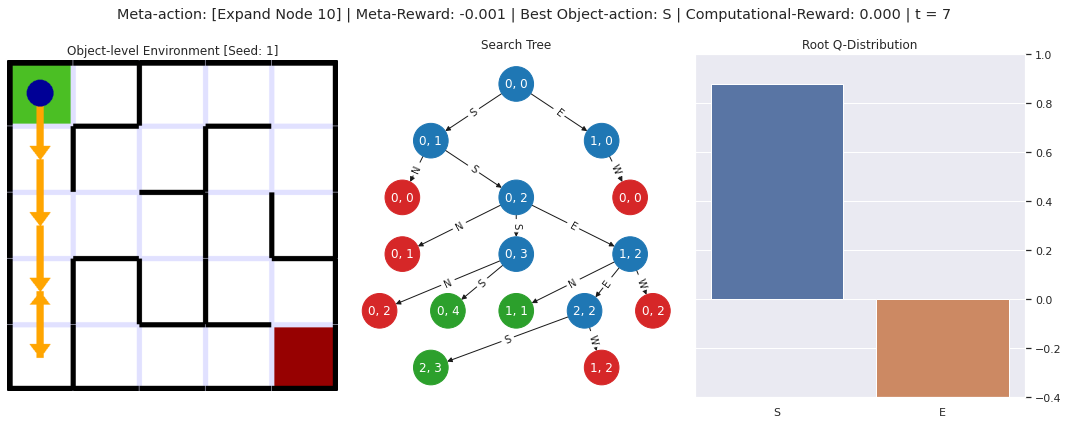

Estimating value of new policy:
 {MazeState(0, 0)}
|---[S, -0.004]--> {MazeState(0, 1)}
	|---[N, -0.004]--> {MazeState(0, 0)}
	|---[S, -0.004]--> {MazeState(0, 2)}
		|---[N, -0.004]--> {MazeState(0, 1)}
		|---[S, -0.004]--> {MazeState(0, 3)}
			|---[N, -0.004]--> {MazeState(0, 2)}
			|---[S, -0.004]--> {MazeState(0, 4)}
				|---[N, -0.004]--> {MazeState(0, 3)}
		|---[E, -0.004]--> {MazeState(1, 2)}
			|---[N, -0.004]--> (MazeState(1, 1))
			|---[E, -0.004]--> {MazeState(2, 2)}
				|---[S, -0.004]--> (MazeState(2, 3))
				|---[W, -0.004]--> {MazeState(1, 2)}
			|---[W, -0.004]--> {MazeState(0, 2)}
|---[E, -0.004]--> {MazeState(1, 0)}
	|---[W, -0.004]--> {MazeState(0, 0)}
P(S | MazeState(0, 0)) = 1.0
P(S | MazeState(0, 1)) = 1.0
P(E | MazeState(0, 2)) = 1.0
P(N | MazeState(1, 2)) = 1.0
P(S | MazeState(1, 1)) = 1.0
Leaf evaluation: Q-hat(MazeState(1, 1), S) = 0.93139
Value(MazeState(1, 1)) = 0.93139
Recursive Q-hat(MazeState(1, 2), N) = 0.918 
Value(MazeState(1, 2)) = 0.91807
Recursive Q-

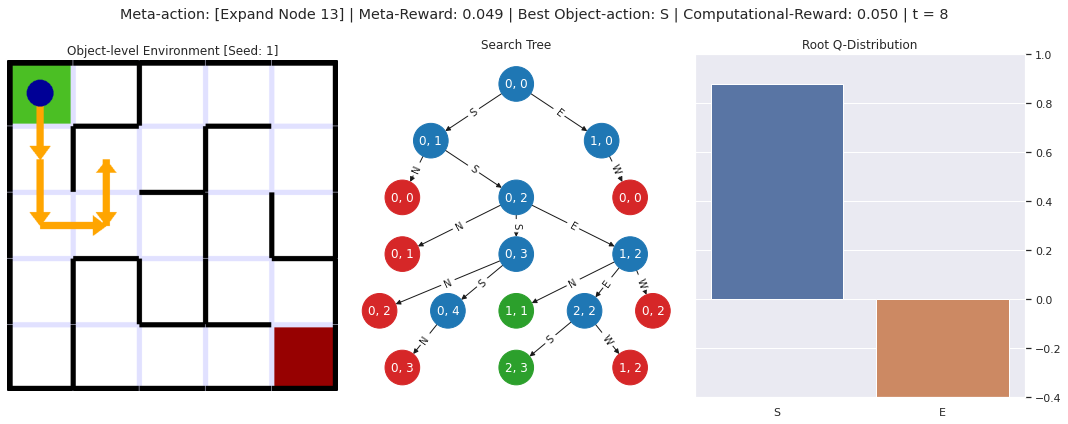

In [8]:
meta_env = create_meta_env(seed=1)
for a in [1, 2, 5, 3, 8, 7, 11]:
    meta_env.step(a)
meta_env.render(plt_show=True)
meta_env.step(14, verbose=True)
meta_env.render(plt_show=True);

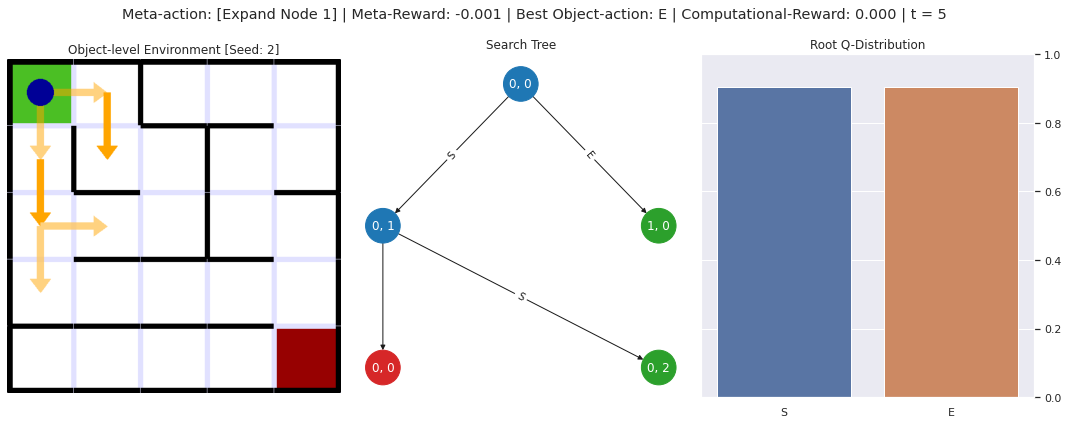

In [11]:
meta_env = create_meta_env(enable_rendering=True)
meta_env.reset()
meta_env.reset()

for i in range(3):
    meta_env.step(0)
meta_env.step(1)
# meta_env.render(plt_show=True);
meta_env.step(2)
# meta_env.step(4)
# meta_env.step(5)
# meta_env.step(0)
meta_env.render(plt_show=True);
# meta_env.step(3)
# # meta_env.step(9, verbose=True)
# meta_env.render(plt_show=True);
# meta_env.step(7, verbose=True)
# meta_env.render(plt_show=True);


In [16]:
node = meta_env.tree.node_list[1]
node.children, node

({-1: [{MazeState(0, 0)}], 1: [(MazeState(0, 2))]},
 {MazeState(0, 1)}
 |---[N, -0.004]--> {MazeState(0, 0)}
 |---[S, -0.004]--> (MazeState(0, 2)))

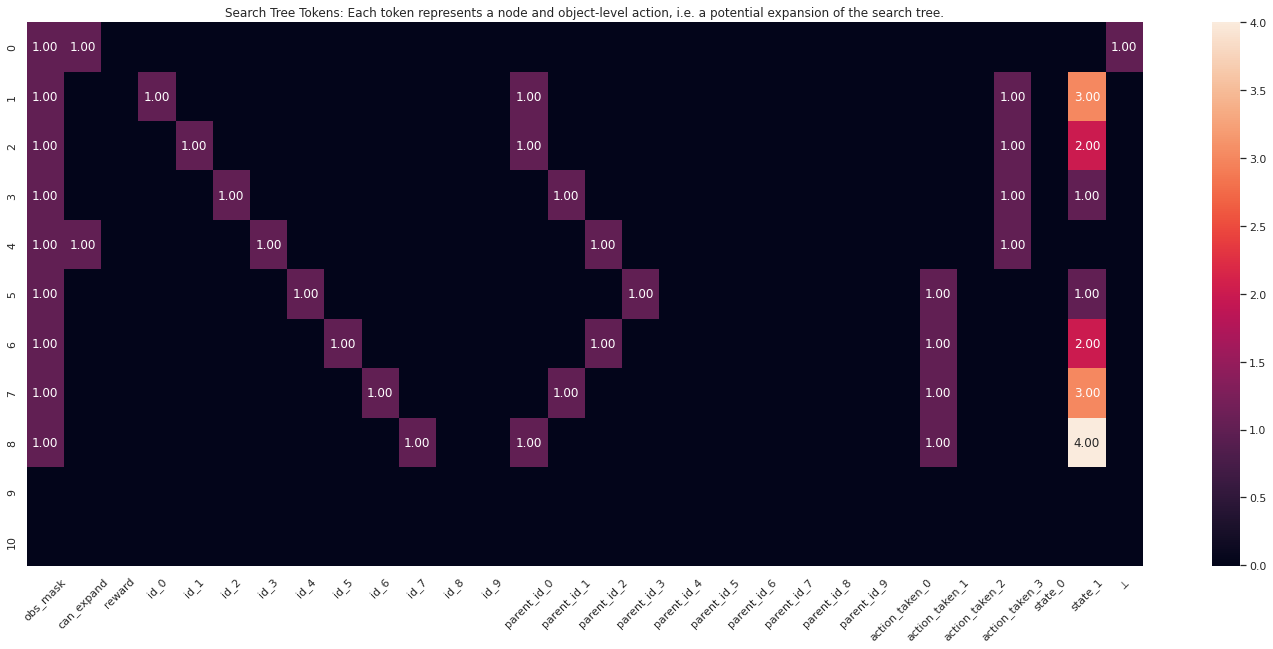

In [8]:
meta_env.plot_search_tokens(annot_fmt='.2f')

In [3]:
import numpy as np
env.reset()

for _ in range(8):
    actions = env.current_time_step().observation['valid_action_mask'].numpy()[0]
    actions[0] = 0
    action = np.random.choice(np.arange(len(actions)), p=actions/actions.sum())
    env.step(action)

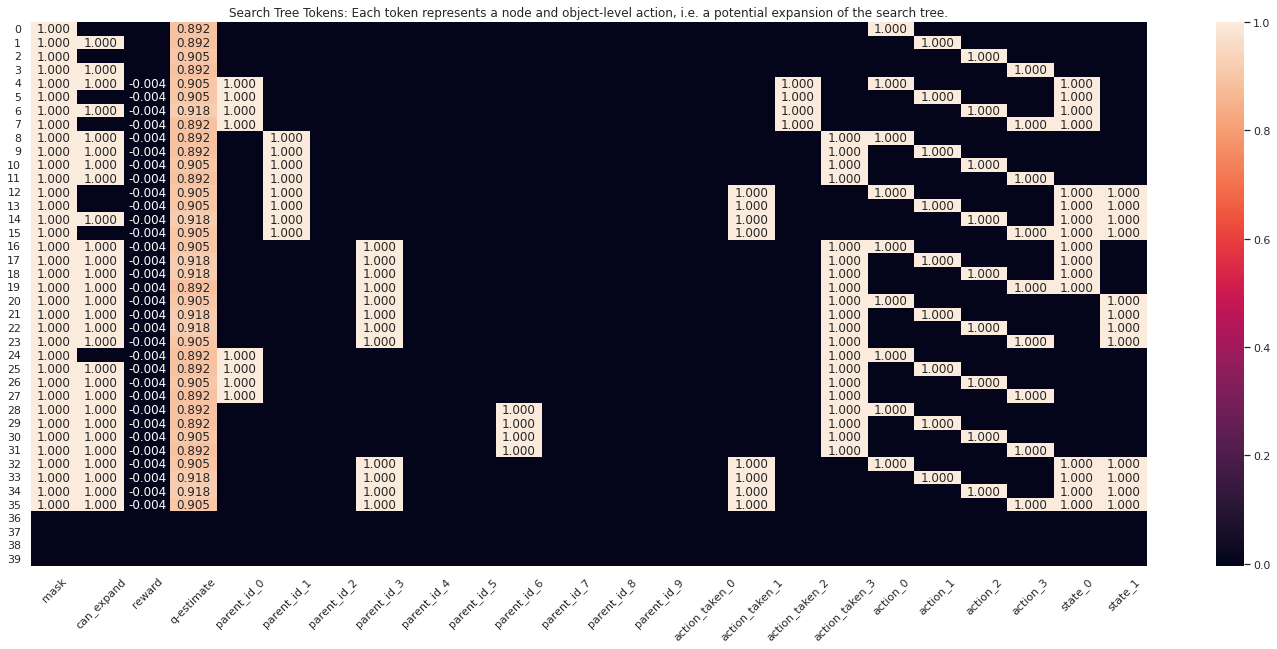

In [5]:
meta_env.plot_search_tokens()

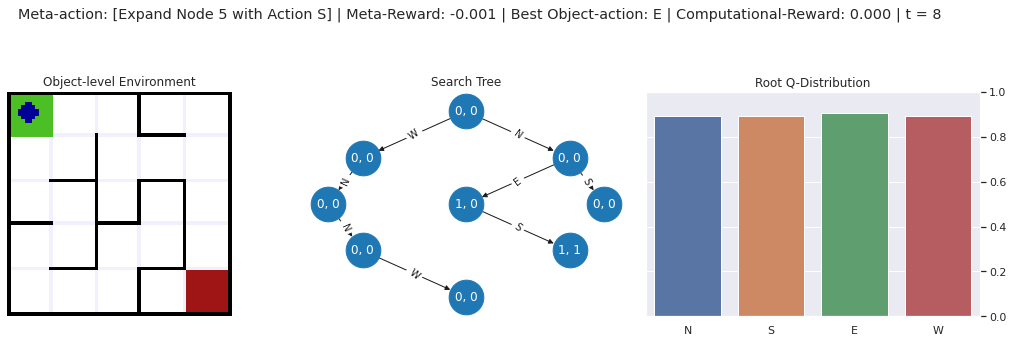

In [15]:
meta_env.render(plt_show=True);

In [ ]:
from mlrl.maze.maze_env import make_maze_env
from mlrl.maze.maze_state import RestrictedActionsMazeState
from mlrl.meta.search_tree import SearchTree
from mlrl.meta.meta_env import MetaEnv
from mlrl.maze.manhattan_q import ManhattanQHat

from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.environments.gym_wrapper import GymWrapper


object_env = make_maze_env(
    seed=0, maze_size=(5, 5), goal_reward=1, render_shape=(64, 64),
    generate_new_maze_on_reset=False
)

q_hat = ManhattanQHat(object_env)
init_state = RestrictedActionsMazeState.extract_state(object_env)
initial_tree = SearchTree(object_env, init_state, q_hat)
meta_env = MetaEnv(object_env, initial_tree, max_tree_size=10, 
                   object_action_to_string=lambda a: object_env.ACTION[a])

env = TFPyEnvironment(GymWrapper(meta_env))

In [10]:
from tf_agents.policies import TFPolicy
from tf_agents.environments.tf_environment import TFEnvironment
import numpy as np


def compute_return_stats(environment: TFEnvironment,
                         policy: TFPolicy,
                         num_episodes: int = 3,
                         max_steps: int = 100) -> float:
    """
    Computes mean and standard deviation for returns of a policy on a given environment.
    """

    returns = []
    rewards = []
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0
        n_steps = 0
        while not time_step.is_last() and n_steps < max_steps:
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
            rewards.append(time_step.reward.numpy()[0])
            n_steps += 1

        returns.append(episode_return)

    returns = np.array(returns)

    return returns.mean(), returns.std(), rewards

In [11]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from mlrl.meta.meta_env import mask_invalid_action_constraint_splitter

random_policy = RandomTFPolicy(
    env.time_step_spec(),
    env.action_spec(),
    observation_and_action_constraint_splitter=mask_invalid_action_constraint_splitter
)

In [43]:
mean_return, return_std, rewards = compute_return_stats(env, random_policy, num_episodes=20)

In [45]:
rewards = [r.numpy()[0] for r in rewards]

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


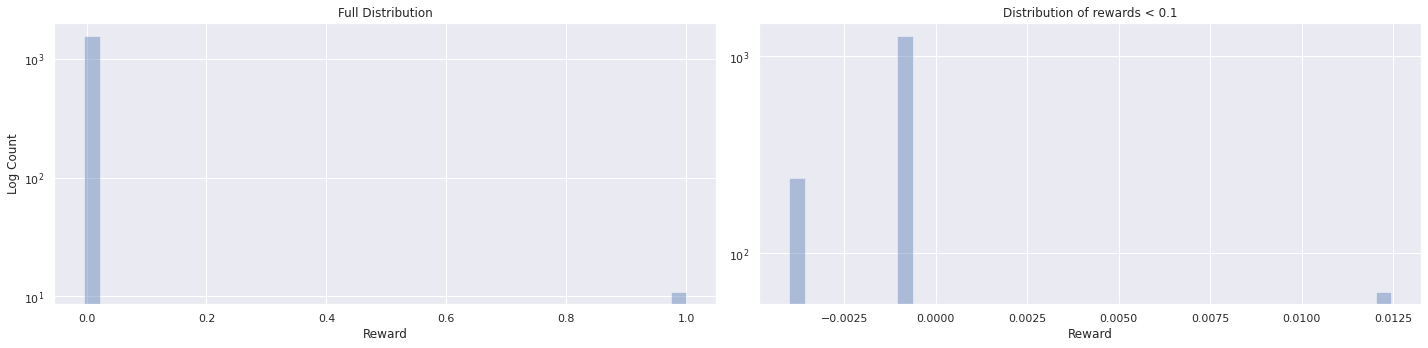

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

t = 0.1

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.distplot(rewards, ax=axs[0], kde=False)
sns.distplot([r for r in rewards if r < t], ax=axs[1], kde=False)

for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel('Reward')

axs[0].set_ylabel('Log Count')
axs[1].set_ylabel('')
axs[0].set_title('Full Distribution')
axs[1].set_title(f'Distribution of rewards < {t}')
plt.tight_layout()
plt.show()